# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

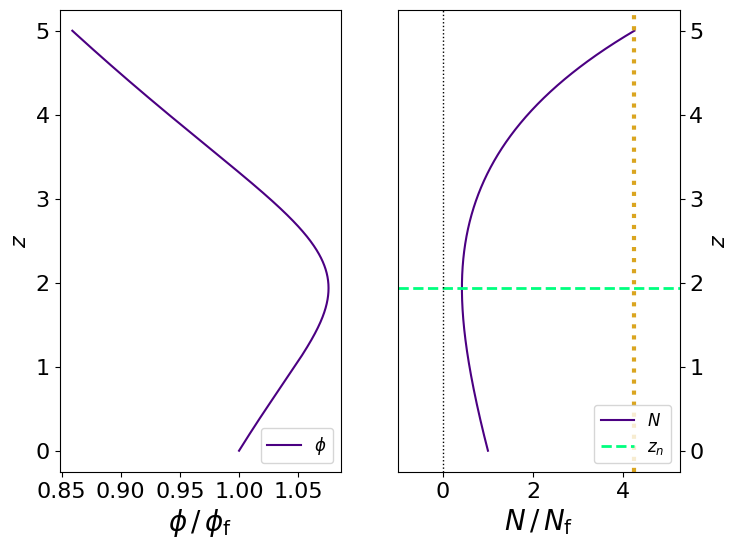

In [4]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 5
z_b = 0 
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

# define initial condition N that satisfies the
# elliptic problem: D(phi,S) N']' = F(phi,S)   
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,eps_min=1e-10)

# interpolate solution, save in numpy arrays, and plot
z,N = interp(initial,domain)
plot_steady(N,z)

In [5]:
# set pulling speed and timesteps 
v_i = 0.03825 
timesteps = np.linspace(0,4e3,4000)

# solve the time-dependent problem
N,z,new_lens = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

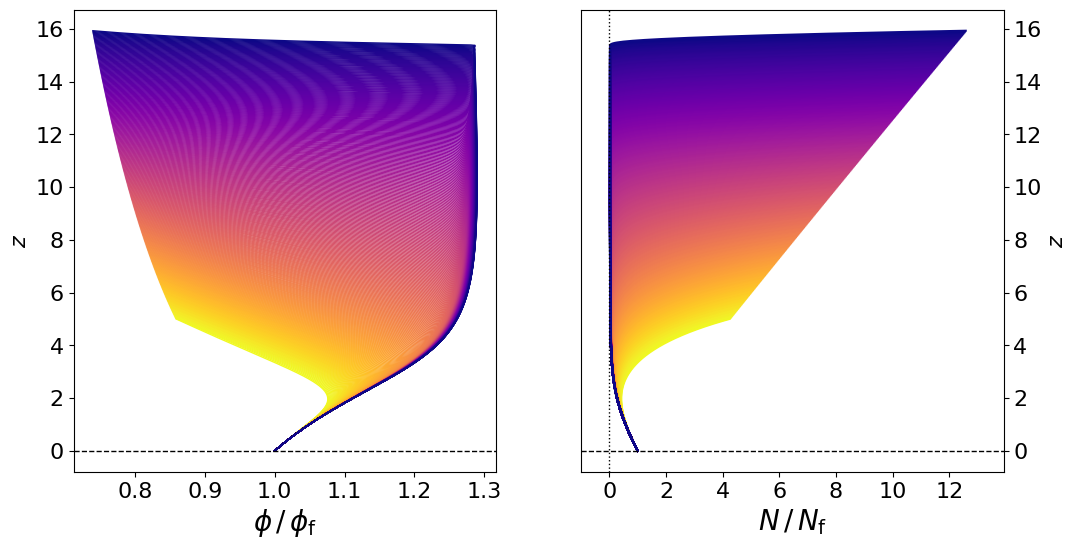

In [6]:
# plot solution up to first ice lens initiation
l0 = np.where(new_lens==1)[0]
if np.size(l0)== 0:
    l0 = None
else:
    l0 = l0[0]
plot(N,z,timesteps[0:l0])

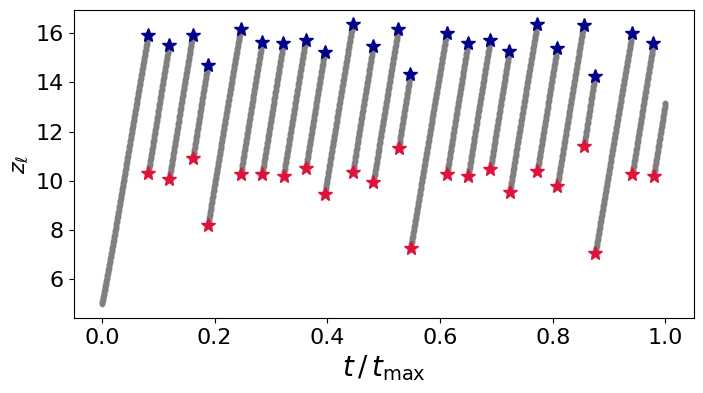

In [9]:
# plot position of active ice lens over time
z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)

plt.figure(figsize=(8,4))
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=3,color='gray')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=10,color='crimson')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=10,color='darkblue')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=16)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.show()
plt.close()